
!{sys.executable} -m pip install mysql-connector-python

import sys

!conda install -y -c conda-forge xgboost

!{sys.executable} -m pip install tensorflow

!{sys.executable} -m pip install --upgrade --no-cache-dir https://get.graphlab.com/GraphLab-Create/2.1/im.dsgeek@gmail.com/AD52-2E93-2425-4198-A108-1635-70FD-8D8D/GraphLab-Create-License.tar.gz

In [93]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
# import mysql.connector
# from mysql.connector import Error
from sklearn.feature_extraction.text import CountVectorizer
# import xgboost as xgb
from sklearn.model_selection import train_test_split

In [94]:
import botocore
import sagemaker
import sys

In [95]:
%%time

import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name

bucket='alitewareml' # put your s3 bucket name here, and create s3 bucket
prefix = 'sagemaker/aliteml'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

CPU times: user 68.3 ms, sys: 0 ns, total: 68.3 ms
Wall time: 138 ms


In [96]:
region

'us-east-2'

# Reading data

In [97]:
train = pd.read_excel('./Intake tracker_12-Nov-2018.xlsx')
print(train.shape)
print(train.columns)
train.head()

(990, 32)
Index(['S.No', 'Search date/IRD', 'Original title', 'Author Names',
       'Author Addresses', 'Correspondence Address', 'Source',
       'Date of Publication', 'Abstract', 'Emtree Drug Index Terms',
       'Drug Tradenames', 'Drug Manufacturer', 'Embase Accession ID', 'PUI',
       'Country of Incidence', 'Initial Reviewer', 'Initial Review Date',
       'Classification (Validity)', 'Duplicates (Yes/No)',
       'Document type (Abs/ FTA)', 'Valid drugs', 'Invalid drugs',
       'Initial Review Comment', 'Quality Reviewer', 'Quality review date',
       'QC comment', 'Full Text Link', 'FTA Order Requested date',
       'FTA Order Receive Date', 'Translation Requested Date',
       'Translation Recieved Date', 'Set'],
      dtype='object')


,S.No,Search date/IRD,Original title,Author Names,Author Addresses,Correspondence Address,Source,Date of Publication,Abstract,Emtree Drug Index Terms,...,Initial Review Comment,Quality Reviewer,Quality review date,QC comment,Full Text Link,FTA Order Requested date,FTA Order Receive Date,Translation Requested Date,Translation Recieved Date,Set
0,933,2018-11-12,Unrecognized Esophageal Perforation After Live...,"Mazilescu L.I., Bezinover D., Paul A., Saner F.H.","(Mazilescu L.I., laura.mazilescu@uk-essen.de; ...","L.I. Mazilescu, Department of General, Viscera...",Journal of Cardiothoracic and Vascular Anesthe...,2018-06-01 00:00:00,NaN,NaN,...,Case report. No safety data in abstract.,Bindu M,2018-11-12,No error,http://dx.doi.org/10.1053/j.jvca.2017.10.035,NaT,NaN,NaN,NaN,Set 8
1,941,2018-11-12,Pretransplant coronary artery disease is a pre...,"Darstein F., Hoppe-Lotichius M., Vollmar J., W...","(Darstein F., felix.darstein@unimedizin-mainz....","F. Darstein, First Department of Internal Medi...",European Journal of Internal Medicine (2018) 5...,2018-05-01 00:00:00,Background: Cardiovascular disease is a seriou...,NaN,...,Set drug (Lenalidomide) is registered in COI. ...,Bindu M,2018-11-12,No error,http://dx.doi.org/10.1016/j.ejim.2017.12.001,NaT,NaN,NaN,NaN,Set 8
2,293,2018-11-12,Ibritumomab tiuxetan (Zevalin) and elevated se...,"Mukherjee S., Ayanambakkam A., Ibrahimi S., Sc...","(Mukherjee S., Sarbajit-Mukherjee@ouhsc.edu; I...","S. Mukherjee, University of Oklahoma Health Sc...",Hematology/ Oncology and Stem Cell Therapy (20...,2018-09-01 00:00:00,Ibritumomab Tiuxetan (Zevalin) is an anti CD-2...,human anti murine antibody (endogenous compoun...,...,Carboplatin has MA in COI. Case report. Partia...,Bindu M,2018-11-12,No error,https://www.sciencedirect.com/science/article/...,NaT,NaN,NaN,NaN,Set 3
3,696,2018-11-12,Management of Pediatric Movement Disorders: Pr...,"Russ J.B., Nallappan A.M., Robichaux-Viehoever A.","(Russ J.B.) Department of Pediatrics, Universi...","A. Robichaux-Viehoever, Department of Neurolog...",Seminars in Pediatric Neurology (2018) 25 (136...,2018-04-01 00:00:00,Management of movement disorders in children i...,NaN,...,Review article. Safety prsent (side effects of...,Bindu M,2018-11-12,No error,https://www.sciencedirect.com/science/article/...,NaT,NaN,NaN,NaN,Set 6
4,814,2018-11-12,Effectiveness of total corpus callosotomy for ...,"Baba S., Okanishi T., Nishimura M., Kanai S., ...","(Baba S.; Okanishi T., t.okanishi@sis.seirei.o...","T. Okanishi, Department of Child Neurology, Se...",Brain and Development (2018) 40:8 (719-723). D...,2018-09-01 00:00:00,"Purpose: Polymicrogyria, a malformation of the...",NaN,...,No MA in COI. Study about effectiveness of tot...,Bindu M,2018-11-12,No error,http://dx.doi.org/10.1016/j.braindev.2018.03.007,NaT,NaN,NaN,NaN,Set 7


In [98]:
data = pd.concat([train['Abstract'], train['Classification (Validity)']], axis=1)
data.columns = ['Abstract', 'Classification']
data.head()

,Abstract,Classification
0,NaN,Rejected
1,Background: Cardiovascular disease is a seriou...,Invalid
2,Ibritumomab Tiuxetan (Zevalin) is an anti CD-2...,Invalid
3,Management of movement disorders in children i...,Invalid
4,"Purpose: Polymicrogyria, a malformation of the...",Rejected


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 2 columns):
Abstract          836 non-null object
Classification    990 non-null object
dtypes: object(2)
memory usage: 15.5+ KB


In [100]:
del train

# Dropping missing values

In [101]:
nanVal = data['Abstract'].isna().sum()
nanVal

154

In [102]:
data = data.dropna()
print(data.shape)
data.head()

(836, 2)


,Abstract,Classification
1,Background: Cardiovascular disease is a seriou...,Invalid
2,Ibritumomab Tiuxetan (Zevalin) is an anti CD-2...,Invalid
3,Management of movement disorders in children i...,Invalid
4,"Purpose: Polymicrogyria, a malformation of the...",Rejected
5,Proteins are often credited as the macromolecu...,Rejected


# Cleaning Data

1.   Tokenizing 
2.   Lemmatizing
3.   Removing Stopwords and Punctuation.



In [103]:
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer

In [104]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [105]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [106]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [107]:
stopword = stopwords.words('english')
len(stopword)
lemmatizer = WordNetLemmatizer()

In [108]:
# stopword

In [109]:
def clean_data(text):
    tokens = nltk.word_tokenize(text)
    no_stop = [word for word in tokens if word not in stopword]
    no_punc = " ".join([lemmatizer.lemmatize(word) for word in no_stop if word not in string.punctuation])
    return no_punc

In [110]:
data['abs_token'] = data['Abstract'].apply(lambda x : clean_data(x))
data.head()

,Abstract,Classification,abs_token
1,Background: Cardiovascular disease is a seriou...,Invalid,Background Cardiovascular disease serious prob...
2,Ibritumomab Tiuxetan (Zevalin) is an anti CD-2...,Invalid,Ibritumomab Tiuxetan Zevalin anti CD-20 murine...
3,Management of movement disorders in children i...,Invalid,Management movement disorder child evolving fi...
4,"Purpose: Polymicrogyria, a malformation of the...",Rejected,Purpose Polymicrogyria malformation cerebral c...
5,Proteins are often credited as the macromolecu...,Rejected,Proteins often credited macromolecule responsi...


# Vectorization

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [112]:
cVect = CountVectorizer()
features_c = cVect.fit_transform(data['abs_token'])
type(features_c)

scipy.sparse.csr.csr_matrix

In [113]:
features_c = pd.DataFrame(features_c.todense())
features_c.columns = cVect.get_feature_names()
features_c.head()

,00,000,00001,0001,00018,0002,0003,0004,0005,0006,...,β2,δ12,δmnn2,η6,κb,μg,μl,μm,μmol,μsv
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(data['abs_token'])
print(type(features))
print(features.shape)
x = features.toarray()

<class 'scipy.sparse.csr.csr_matrix'>
(836, 12861)


In [115]:
labels = data['Classification']
uniq_labels = list(set(labels))
print(uniq_labels)
labels.head()

['Rejected', 'Invalid', 'Invalid-awaiting FTA', 'Valid']


1     Invalid
2     Invalid
3     Invalid
4    Rejected
5    Rejected
Name: Classification, dtype: object

In [116]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)
print(labels[:10])
set(labels)

[0 0 0 2 2 2 0 2 2 0]


{0, 1, 2, 3}

In [159]:
le.inverse_transform(1)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'Invalid-awaiting FTA'

In [117]:
rej = sum(data['Classification'] == 'Rejected')
invalid = sum(data['Classification'] == 'Invalid')
valid = sum(data['Classification'] == 'Valid')
awaitFTA = sum(data['Classification'] == 'Invalid-awaiting FTA')

In [160]:
counts = [rej, invalid, awaitFTA, valid]
counts

[337, 418, 59, 22]

# Plotting the Data

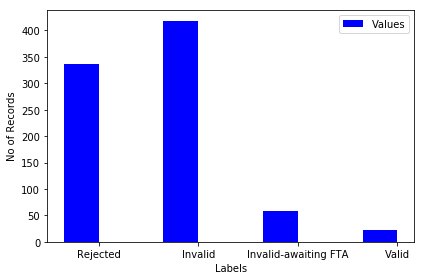

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

index = np.arange(4)
fig, ax = plt.subplots()
rect = ax.bar(index, counts, 0.35, color='b', label='Values')
ax.set_xlabel('Labels')
ax.set_ylabel('No of Records')
ax.set_xticks(index + 0.35/2)
ax.set_xticklabels(uniq_labels)
ax.legend()
fig.tight_layout()
plt.show()

Text(0.5,0,'Labels')

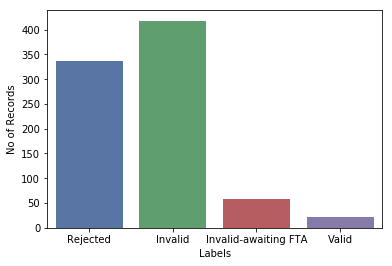

In [162]:
f, ax1 = plt.subplots()
sns.barplot(x=uniq_labels, y=counts, palette="deep", ax=ax1)
ax1.set_ylabel("No of Records")
ax1.set_xlabel("Labels")

# Splitting the data

In [121]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3)

In [170]:
print(features_train.shape)
print(features_test.shape)
labels_train.shape

(585, 12861)
(251, 12861)


(585,)

# Training SageMaker model

In [123]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')

In [124]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [125]:
%%time
clf1 = xgb.XGBClassifier()
clf1.fit(features, labels)

CPU times: user 13.9 s, sys: 0 ns, total: 13.9 s
Wall time: 13.9 s


In [126]:
%%time
import pickle, gzip, numpy, urllib.request, json

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 15 µs


In [127]:
model_file_name = "xgboost-model"
clf1._Booster.save_model(model_file_name)

In [128]:
!tar czvf model.tar.gz $model_file_name

xgboost-model


In [129]:
fObj = open("model.tar.gz", 'rb')
key= os.path.join(prefix, model_file_name, 'model.tar.gz')
boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fObj)

In [130]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

## Creating Endpoint Configuration

In [71]:
%%time
from time import gmtime, strftime

model_name = model_file_name + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = 'https://s3-{}.amazonaws.com/{}/{}'.format(region,bucket,key)
sm_client = boto3.client('sagemaker')

print (model_url)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_url,
}

create_model_response2 = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response2['ModelArn'])

https://s3-us-east-2.amazonaws.com/alitewareml/sagemaker/aliteml/xgboost-model/model.tar.gz
arn:aws:sagemaker:us-east-2:947903643832:model/xgboost-model2019-03-28-16-37-02
CPU times: user 50.5 ms, sys: 0 ns, total: 50.5 ms
Wall time: 328 ms


In [74]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'InitialVariantWeight':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2019-03-28-16-39-47
Endpoint Config Arn: arn:aws:sagemaker:us-east-2:947903643832:endpoint-config/demo-xgboostendpointconfig-2019-03-28-16-39-47


## Creating Endpoint

In [75]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2019-03-28-16-39-48
arn:aws:sagemaker:us-east-2:947903643832:endpoint/demo-xgboostendpoint-2019-03-28-16-39-48
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-2:947903643832:endpoint/demo-xgboostendpoint-2019-03-28-16-39-48
Status: InService
CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 8min 1s


In [76]:
endpoint_name

'DEMO-XGBoostEndpoint-2019-03-28-16-39-48'

# Perform Prediction

In [131]:
record = "Objective To explore the role and possible mechanism of grainyhead-like protein 2 (GRHL2) down-regulation in acquired drug resistance to tumor-targeted therapeutic drug gefitinib, an epidermal growth factor receptor tyrosine kinase inhibitor (EGFR-TKI). Methods Human colon cancer cell line DiFi and human lung adenocarcinoma cell line HCC4006 were cultured in a stepwise increasing concentration of gefitinib to obtain gefitinib-resistant cell lines. The differentially expressed genes between gefitinib-resistant cell lines and parent cells were selected by RNA sequencing and verified by real-time fluorescent quantitative PCR (qRT-PCR). The pcDNA3.1-GRHL2 plasmid was transfected into the gefitinib-resistant cell lines to overexpress GRHL2, and the sensitivity of the cells to gefitinib was detected by CCK-8 method. The expression of epithelial marker (E-cadherin) and mesenchymal marker (Vimentin) in the gefitinib-resistant cells was detected by Western blotting. The relationship between GRHL2 expression and expression of E-cadherin and Vimentin in 60 human tumor cell lines was analyzed by CellMiner™ database. Results We successfully obtained two gefitinib-resistant cell lines. RNA sequencing and qRT-PCR confirmed that the expression of GRHL2 in the gefitinib-resistant cells was decreased, while the sensitivity of the cells to gefitinib was restored after overexpressing GRHL2 in the gefitinib-resistant cells. Western blotting analysis showed that the E-cadherin expression was decreased and the Vimentin expression was increased in the gefitinib-resistant cell line. CellMiner™ database analysis showed that the expression of GRHL2 was highly consistent with the ratio of E-cadherin to Vimentin. Conclusion Down-regulation of GRHL2 mediates drug resistance of tumor cell to gefitinib by inducing epithelial-mesenchymal transition"

In [188]:
clean_rec = clean_data(record)
clean_rec = [clean_rec]
# print(clean_rec)

In [81]:
vect = vectorizer.transform(clean_rec)
vect

<1x12861 sparse matrix of type '<class 'numpy.float64'>'
	with 99 stored elements in Compressed Sparse Row format>

In [145]:
df = pd.DataFrame(vect.todense())
# df.columns = vectorizer.get_feature_names()
df

,0,1,2,3,4,5,6,7,8,9,...,12851,12852,12853,12854,12855,12856,12857,12858,12859,12860
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [192]:
test_df = pd.read_csv('test.csv')
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12851,12852,12853,12854,12855,12856,12857,12858,12859,12860
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
df.to_csv('test.csv', index=False)

In [186]:
pred = model.predict(vect)
print(pred)
le.inverse_transform(model.predict_classes(vect))

[[0.634191   0.00397333 0.35686442 0.00497124]]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['Invalid'], dtype=object)

In [189]:
%%time
import json


file_name = 'test.csv' #customize to your test file, will be 'mnist.single.test' if use data above

with open(file_name, 'r') as f:
    payload = f.read().strip()

CPU times: user 483 µs, sys: 84 µs, total: 567 µs
Wall time: 403 µs


In [181]:
arr = payload.split('\n')
test_data = arr[1]
# print((arr[0]))

In [ ]:
runtime_client = boto3.client('runtime.sagemaker')

In [194]:
type(test_data)

str

In [193]:
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name,
                                          ContentType='text/csv',
                                   Body=test_data)
result = response['Body'].read().decode('ascii')
print('Predicted Class Probabilities: {}.'.format(result))

Predicted Class Probabilities: [0.39683854579925537, 0.06537406891584396, 0.1624053418636322, 0.37538206577301025].


In [191]:
endpoint_name

'DEMO-XGBoostEndpoint-2019-03-28-16-39-48'

In [190]:
response

{'ResponseMetadata': {'RequestId': '927bc33f-dbb4-44c5-99a3-79b76d3eec85',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '927bc33f-dbb4-44c5-99a3-79b76d3eec85',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Tue, 2 Apr 2019 10:41:56 GMT',
   'content-type': 'text/csv; charset=utf-8',
   'content-length': '83'},
  'RetryAttempts': 0},
 'ContentType': 'text/csv; charset=utf-8',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7f33901fe208>}

In [183]:
floatArr = np.array(json.loads(result))
predictedLabel = np.argmax(floatArr)
print('Predicted Class Label: {}.'.format(predictedLabel))
# print('Actual Class Label: {}.'.format(point_y))

Predicted Class Label: 0.


In [184]:
decodeLabel = le.inverse_transform(predictedLabel)
decodeLabel

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'Invalid'

runtime_client.generate_presigned_url(ClientMethod='runtime.sagemaker',
    Params={
        'Bucket': bucket,
        'Key': key
    })

clf1.score(features_test, labels_test)

# Training Deep Learning Model

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [27]:
from keras.utils import to_categorical
y_binary = to_categorical(labels, 4)

In [28]:
print(y_binary.shape)
y_binary

(836, 4)


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [29]:
shape = features.shape
shape

(836, 12861)

In [30]:
model = Sequential()
model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='sigmoid'))
# model.add(Dense(64, activation='tanh'))
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# model.add(Dense(64, activation='relu',
#                 input_shape = shape))
# model.add(Dense(20, activation='relu'))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(4, activation='softmax'))

In [31]:
model.layers

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
             metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
model.fit(features.todense(), y_binary, batch_size=64, epochs=50, verbose=1, validation_split=0.3)

Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 251 samples
Epoch 1/50
585/585 [==============================] - 1s 2ms/step - loss: 1.3122 - acc: 0.4974 - val_loss: 1.2123 - val_acc: 0.4821
Epoch 2/50
585/585 [==============================] - 1s 872us/step - loss: 1.0455 - acc: 0.6342 - val_loss: 1.0749 - val_acc: 0.4980
Epoch 3/50
585/585 [==============================] - 1s 886us/step - loss: 0.8121 - acc: 0.7538 - val_loss: 1.0100 - val_acc: 0.5219
Epoch 4/50
585/585 [==============================] - 1s 894us/step - loss: 0.6283 - acc: 0.8410 - val_loss: 0.9833 - val_acc: 0.5817
Epoch 5/50
585/585 [==============================] - 1s 907us/step - loss: 0.4705 - acc: 0.9043 - val_loss: 0.9692 - val_acc: 0.5697
Epoch 6/50
585/585 [==============================] - 1s 897us/step - loss: 0.3458 - acc: 0.9231 - val_loss: 0.9734 - val_acc: 0.5737
Epoch 7/50
585/585 [==============================] - 1s 911us/step - loss: 0.2473 - acc: 0.9556 - val_l

In [34]:
tensorboard = TensorBoard('./sample_data/modelLogs')

In [35]:
# features_train = np.reshape(features_train.toarray(), (features_train[0], 1, features_train[1]))

In [36]:
features.shape

(836, 12861)

In [37]:
type(features.todense())

numpy.matrixlib.defmatrix.matrix

In [38]:
features.todense()[1]

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               3292672   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 3,293,700
Trainable params: 3,293,700
Non-trainable params: 0
_________________________________________________________________


In [40]:
from keras.utils import plot_model
plot_model(model, to_file="model.png", show_layer_names=True, show_shapes=True)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [ ]:
model.save('my_model.h5')

In [ ]:
pred = model.predict(features_test)

In [41]:
model.deploy(initial_instance_count = 0,instance_type = 'ml.t2.medium')

AttributeError: 'Sequential' object has no attribute 'deploy'

In [ ]:
classes = model.predict_classes(features_test)
# le.inverse_transform(classes)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(labels_test, classes)

In [ ]:
for i in pred:
  print(i)

In [ ]:
def trainClf(est, jobs, dept):
    clf = xgb.XGBClassifier(n_estimators=est, n_jobs=jobs, max_depth=dept)
    clf.fit(features_train, labels_train)
    score = clf.score(features_test, labels_test)
    print("For {0} estimators, {1} jobs , {2} max_depth Score is {3}".format(est, jobs, dept, score)) 

In [ ]:
est = [100, 200, 300, 400]
jobs = [3, 4, 5]
dept = [3, 4, 5]

In [ ]:
# for e in est:
#     for j in jobs:
#         for d in dept:
#             trainClf(e, j, d)

In [ ]:
pred = clf1.predict(features_test)
pred[:10]

In [ ]:
clf1.score(features_test, labels_test)

In [ ]:
%%time
clf2 = RandomForestClassifier()
clf2.fit(features_train, labels_train)

In [ ]:
pred = clf2.predict(features_test)
pred[:10]

In [ ]:
clf2.score(features_test, labels_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [200, 250, 300, 350]}
gridscv = GridSearchCV(clf1, parameters, cv=5)

In [ ]:
# gridscv.fit(clf1, features_train, labels_train)

In [ ]:
# vectorizer2 = TfidfVectorizer(analyzer=clean_data)
# vect_t = vectorizer2.fit_transform(data['Abstract'])
# vect_t.toarray()